In [15]:
import pandas as pd
import numpy as np

import sys
import os
current_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from dataHandler.preprocessor import Preprocessor
from sklearn import model_selection

__Accesing data__

In [16]:
directory = "/home/michal/Desktop/UniversityOfEssex/MasterProject/22-24_CE901-CE911-CF981-SU_kaczmarczyk_michal_p/data/Bloomberg/"
files = os.listdir(directory)
files = [f for f in files if os.path.isfile(directory+'/'+f)]
files
files = ["RR.L.csv"]

In [17]:
dataDir = "/home/michal/Desktop/UniversityOfEssex/MasterProject/22-24_CE901-CE911-CF981-SU_kaczmarczyk_michal_p/data/data/"
dataset = []
for file in files:
    df = pd.read_csv(dataDir + file).set_index("Date")
    df.index = pd.to_datetime(df.index)
    bl = pd.read_csv(directory + file).set_index("Date")
    bl.index = pd.to_datetime(bl.index)
    bl = bl["Price Earnings Ratio \n(P/E) \n(RR/ LN Equity)"]
    bl = bl.resample('D')
    bl = bl.ffill()
    bl = bl.bfill()
    df = df.join(bl, how="inner")
    dataset.append(df)

__Splitting data__

In [18]:
trainDataset = []
testDataset = []
preprocessor = Preprocessor()
i=0
for df in dataset:
    df.insert(0, "Date", df.index)
    df = preprocessor.leaveDataSinceDate(df)
    #if files[i] == "RR.L.csv":
    train, test = model_selection.train_test_split(df, test_size=0.2, shuffle=False)
    trainDataset.append(train)
    testDataset.append(test)
    #else:
    #    trainDataset.append(df)
    i+=1

__Preprocessing data__

In [19]:
preprocessor = Preprocessor()
for i in range(len(trainDataset)):
    trainDataset[i] = preprocessor.dropUnnamedColumn(trainDataset[i])
    trainDataset[i] = preprocessor.dropDuplicates(trainDataset[i])
    trainDataset[i] = preprocessor.addChangeFeature(trainDataset[i])
    columns = trainDataset[i].columns
    trainDataset[i][columns[1:]] = preprocessor.fillMissingData(trainDataset[i][columns[1:]])
    trainDataset[i][columns[1:]] = preprocessor.scaleData(trainDataset[i][columns[1:]])
    trainDataset[i] = preprocessor.sortValuesByDate(trainDataset[i])
    trainDataset[i].set_index("Date", inplace = True)

In [20]:
preprocessor = Preprocessor()
for i in range(len(testDataset)):
    testDataset[i] = preprocessor.dropUnnamedColumn(testDataset[i])
    testDataset[i] = preprocessor.dropDuplicates(testDataset[i])
    testDataset[i] = preprocessor.addChangeFeature(testDataset[i])
    columns = testDataset[i].columns
    testDataset[i][columns[1:]] = preprocessor.fillMissingData(testDataset[i][columns[1:]])
    testDataset[i][columns[1:]] = preprocessor.scaleData(testDataset[i][columns[1:]])
    testDataset[i] = preprocessor.sortValuesByDate(testDataset[i])
    testDataset[i].set_index("Date", inplace = True)

preprocessor.saveScalers()

In [21]:
trainDataset[0]

,Open,High,Low,Close,Adj Close,Volume,Price Earnings Ratio \n(P/E) \n(RR/ LN Equity),Change[%]
Date,,,,,,,,
2014-06-27,0.959673,0.969492,0.968438,0.974500,0.902035,0.035655,0.081934,0.308960
2014-06-30,0.978050,0.970217,0.968438,0.974500,0.902035,0.044695,0.042722,0.308960
2014-07-01,0.973966,0.969581,0.975565,0.975520,0.902990,0.034988,0.042722,0.310437
2014-07-02,0.981113,0.976275,0.961311,0.953080,0.881989,0.034193,0.042722,0.276492
2014-07-03,0.954569,0.965169,0.962533,0.968380,0.896308,0.041117,0.042722,0.331562
...,...,...,...,...,...,...,...,...
2022-05-23,0.135479,0.134483,0.140768,0.131244,0.134145,0.086532,0.335248,0.305738
2022-05-24,0.128190,0.127087,0.134775,0.122149,0.124849,0.153849,0.335248,0.250840
2022-05-25,0.124590,0.130620,0.135250,0.132374,0.135300,0.099908,0.335248,0.376795


__Creating training sequences__

In [22]:
def createSequence(dataX, dataY, lengthX, predictionHorizont):
    xData = []
    yData = []
    for i in range(len(dataX) - lengthX - predictionHorizont):
        xData.append(dataX[i:i+lengthX].values)
        yData.append(dataY[(lengthX + i):(lengthX + predictionHorizont + i)].values)
    return xData, yData

features = len(trainDataset[0].iloc[0])
samplesForPrediction = 15
samplesPredicted = 1

trainDates = trainDataset[0].index[samplesForPrediction+1:]
testDates = testDataset[0].index[samplesForPrediction+1:]
xTrain = []
yTrain = []
xTest = []
yTest = []
for df in trainDataset:
    trainX, trainY = createSequence(df, df["Close"], samplesForPrediction, samplesPredicted)
    xTrain += trainX
    yTrain += trainY
for df in testDataset:
    testX, testY = createSequence(df, df["Close"], samplesForPrediction, samplesPredicted)
    xTest += testX
    yTest += testY

__Making pyTorch Dataset__

In [23]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [24]:
xTrain = torch.Tensor(xTrain).to(device)
yTrain = torch.Tensor(yTrain).to(device)
xTest = torch.Tensor(xTest).to(device)
yTest = torch.Tensor(yTest).to(device)

In [25]:
print(xTrain)

tensor([[[0.9597, 0.9695, 0.9684,  ..., 0.0357, 0.0819, 0.3090],
         [0.9781, 0.9702, 0.9684,  ..., 0.0447, 0.0427, 0.3090],
         [0.9740, 0.9696, 0.9756,  ..., 0.0350, 0.0427, 0.3104],
         ...,
         [0.9515, 0.9497, 0.9521,  ..., 0.0354, 0.0414, 0.2954],
         [0.9484, 0.9642, 0.9562,  ..., 0.0355, 0.0414, 0.3393],
         [0.9607, 0.9581, 0.9532,  ..., 0.0255, 0.0414, 0.2777]],

        [[0.9781, 0.9702, 0.9684,  ..., 0.0447, 0.0427, 0.3090],
         [0.9740, 0.9696, 0.9756,  ..., 0.0350, 0.0427, 0.3104],
         [0.9811, 0.9763, 0.9613,  ..., 0.0342, 0.0427, 0.2765],
         ...,
         [0.9484, 0.9642, 0.9562,  ..., 0.0355, 0.0414, 0.3393],
         [0.9607, 0.9581, 0.9532,  ..., 0.0255, 0.0414, 0.2777],
         [0.9372, 0.9298, 0.9359,  ..., 0.0261, 0.0411, 0.2968]],

        [[0.9740, 0.9696, 0.9756,  ..., 0.0350, 0.0427, 0.3104],
         [0.9811, 0.9763, 0.9613,  ..., 0.0342, 0.0427, 0.2765],
         [0.9546, 0.9652, 0.9625,  ..., 0.0411, 0.0427, 0.

__Model__

In [26]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_seq_length: int = 5000):
        super().__init__()

        position = torch.arange(max_seq_length).unsqueeze(1)
        div_term = torch.pow(10000, torch.arange(0, d_model, 2).float() / d_model)

        pe = torch.zeros(max_seq_length, d_model)
        pe[:, 0::2] = torch.sin(position / div_term)
        pe[:, 1::2] = torch.cos(position / div_term)

        pe = pe.unsqueeze(0).transpose(0, 1)

        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:x.size(0), :]
        return x

class TransformerModel(nn.Module):
    def __init__(self, feature_size, d_model, nhead, num_layers = 6, dim_feedforward = 512, dropout=0.1):
        super(TransformerModel, self).__init__()
        #self.encEmbedding = nn.Embedding(feature_size, d_model)
        #self.decEmbedding = nn.Embedding(feature_size, d_model)
        self.encEmbedding = nn.Linear(feature_size, d_model)
        self.decEmbedding = nn.Linear(feature_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward = dim_feedforward, dropout = dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward = dim_feedforward, dropout = dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.linear = nn.Linear(d_model, feature_size)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, tgt):
      src = self.encEmbedding(src)
      tgt = self.decEmbedding(tgt)
      src = self.pos_encoder(src)
      tgt = self.pos_encoder(tgt)

      tgt_mask = self.generate_square_subsequent_mask(tgt.size(0)).to(tgt.device)
      memory = self.transformer_encoder(src, mask = None)
      output = self.transformer_decoder(tgt = tgt, memory = memory, tgt_mask = tgt_mask)
      output = self.linear(output)
      return output


# Model parameters
feature_size = features  # As we're working with 1D time series
d_model = 128  # Embedding dimension
nhead = 8  # Number of attention heads
num_layers = 6  # Number of transformer layers
dim_feedforward = 512  # Dimension of the feedforward network

# Initialize the model
model = TransformerModel(feature_size, d_model, nhead, num_layers, dim_feedforward).to(device)

print(model)

TransformerModel(
  (encEmbedding): Linear(in_features=8, out_features=128, bias=True)
  (decEmbedding): Linear(in_features=8, out_features=128, bias=True)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (transformer_decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-5): 6 x T

/home/michal/.local/lib/python3.9/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [27]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

In [28]:
print(xTrain.shape)
loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(xTrain, yTrain), shuffle=False, batch_size=1)
for inputData, desired in loader:
    print(inputData.shape)
    print(desired.shape)
    break

torch.Size([1987, 15, 8])
torch.Size([1, 15, 8])
torch.Size([1, 1])


In [29]:
def trainLoop(epochs):
    train_loss = []
    test_loss = []
    for epoch in range(epochs):
        model.train()
        for inputData, desired in loader:
            inputData = inputData.to(device)
            desired = desired.to(device)
            pred = model(inputData, inputData)
            loss = loss_fn(pred, desired)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        model.eval()
        with torch.no_grad():
            y_pred = model(xTrain.permute(1, 0, 2).to(device), xTrain.permute(1, 0, 2).to(device))
            train_loss.append(loss_fn(y_pred, yTrain).cpu().numpy().tolist())
            y_pred = model(xTest.permute(1, 0, 2).to(device), xTest.permute(1, 0, 2).to(device))
            test_loss.append(loss_fn(y_pred, yTest).cpu().numpy().tolist())
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss[-1:]}, Test Loss: {test_loss[-1:]}')
    return train_loss, test_loss


#model = torch.load('model.pth')
train_loss, test_loss = trainLoop(100)
#torch.save(model, 'model.pth')

#550Epochs

/home/michal/.local/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 15, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/michal/.local/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1987, 1])) that is different to the input size (torch.Size([15, 1987, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/michal/.local/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([485, 1])) that is different to the input size (torch.Size([15, 485, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure th

Epoch [1/100], Train Loss: [0.2535358965396881], Test Loss: [0.11866065114736557]
Epoch [2/100], Train Loss: [0.2723575532436371], Test Loss: [0.12739957869052887]


KeyboardInterrupt: 

NameError: name 'train_loss' is not defined

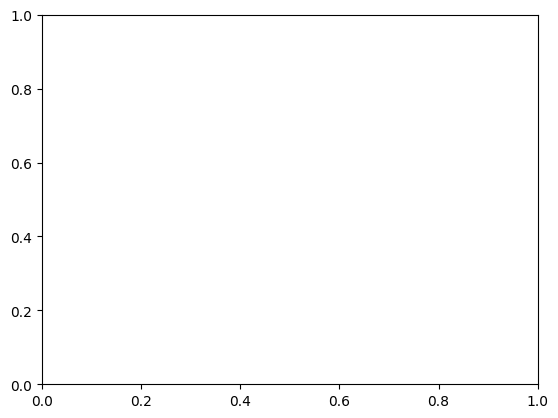

In [30]:
fig, ax = plt.subplots()
ax.plot(train_loss)
ax.plot(test_loss)
ax.legend(["train loss", "test loss"])
ax.grid()
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.title("Loss functions")
plt.show()

__Testing__

In [31]:
# Make predictions
y_pred = model(xTrain.permute(1, 0, 2)).cpu()

y_pred = y_pred.detach().numpy()


# Calculate the mean squared error across all outputs
mse_total = mean_squared_error(yTrain.cpu().detach().numpy(), y_pred)
print(f'Total Mean Squared Error: {mse_total}')

set = 5*2
real = np.concatenate(yTrain.cpu().detach().numpy()[::samplesPredicted])
predictions = np.concatenate(y_pred[::samplesPredicted])

fig, ax = plt.subplots()
#ax.plot(trainDates, real, zorder = 3)
#ax.plot(trainDates, predictions, color = 'black', zorder = 2)
ax.plot(real, zorder = 3)
ax.plot(predictions, color = 'black', zorder = 2)

# Rotate date labels for better readability
#plt.xticks(rotation=45)

# Optionally, set the locator to have fewer ticks
#locator = plt.matplotlib.dates.AutoDateLocator(minticks=10, maxticks=20)
#ax.xaxis.set_major_locator(locator)


ax.legend(["Real", "Prediction"])
#ax.axvspan(0, 4, facecolor='lightblue', alpha=0.5, zorder = 1)  # First part
#ax.axvspan(4, 9, facecolor='lightgreen', alpha=0.5, zorder = 1)  # Second part
#ax.axvspan(9, 14, facecolor='tomato', alpha=0.5, zorder = 1)  # Second third
#ax.set_ylim([0, 1])
ax.grid()
plt.ylabel("Scaled closing")
plt.xlabel("Day number")
plt.title("Prediction for 1 day using last 10 days - train set")
plt.show()



TypeError: forward() missing 1 required positional argument: 'tgt'

In [ ]:
# Make predictions
y_pred = model(xTest.permute(1, 0, 2)).cpu()

y_pred = y_pred.detach().numpy()

# Calculate the mean squared error across all outputs
mse_total = mean_squared_error(yTest.cpu().detach().numpy(), y_pred)
print(f'Total Mean Squared Error: {mse_total}')

set = 5*2
real = np.concatenate(yTest.cpu().detach().numpy()[::samplesPredicted])
predictions = np.concatenate(y_pred[::samplesPredicted])

#Rescaling
dummyDataset = testDataset[0].tail(len(predictions))
dummyDataset["Close"] = predictions
dummyDataset = preprocessor.scaler.inverse_transform(dummyDataset)
predictions = dummyDataset[:,3]

dummyDataset = testDataset[0].tail(len(real))
dummyDataset["Close"] = real
dummyDataset = preprocessor.scaler.inverse_transform(dummyDataset)
real = dummyDataset[:,3]

fig, ax = plt.subplots()
ax.plot(np.array(testDates)[-50:], real[-50:], zorder = 3)
ax.plot(np.array(testDates)[-50:], predictions[-50:], color = 'black', zorder = 2)

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Optionally, set the locator to have fewer ticks
locator = plt.matplotlib.dates.AutoDateLocator(minticks=10, maxticks=20)
ax.xaxis.set_major_locator(locator)

ax.legend(["Real", "Prediction"])
#ax.axvspan(0, 4, facecolor='lightblue', alpha=0.5, zorder = 1)  # First part
#ax.axvspan(4, 9, facecolor='lightgreen', alpha=0.5, zorder = 1)  # Second part
#ax.axvspan(9, 14, facecolor='tomato', alpha=0.5, zorder = 1)  # Second third
#ax.set_ylim([0, 1])
ax.grid()
plt.ylabel("Scaled closing")
plt.xlabel("Day number")
plt.title("Prediction for 1 day using last 10 days - test set")
plt.show()



__Profit Calculation__

In [ ]:
profit = 0
lastBuy = 0
action = []
for realVal, predVal in zip(real[:-samplesPredicted], predictions[samplesPredicted::samplesPredicted]):
    if(realVal<predVal and lastBuy == 0):
        lastBuy = realVal
        action.append(1)
    elif(realVal > predVal and lastBuy > 0):
        profit += realVal - lastBuy
        lastBuy = 0
        action.append(-1)
    else:
        action.append(0)

if(lastBuy>0):
    profit += realVal - lastBuy
    lastBuy = 0
    action.append(-1)
else:
    action.append(0)

print(profit)

In [ ]:
real = real[:]
predictions = predictions[:]
testDates = testDates[:]
action = np.array(action[:])

buy_dates = np.array(testDates)[action == 1]
sell_dates = np.array(testDates)[action == -1]

buy_prices = real[action == 1]
sell_prices = real[action == -1]

fig, ax = plt.subplots()
ax.plot(np.array(testDates), real, zorder = 3)
ax.plot(np.array(testDates), predictions, color = 'black', zorder = 2)

ax.scatter(buy_dates, buy_prices, color='green', marker='^', s=100, label='Buy')
ax.scatter(sell_dates, sell_prices, color='red', marker='v', s=100, label='Sell')

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Optionally, set the locator to have fewer ticks
locator = plt.matplotlib.dates.AutoDateLocator(minticks=10, maxticks=20)
ax.xaxis.set_major_locator(locator)

ax.legend(["Real", "Prediction"])
ax.grid()
plt.ylabel("Scaled closing")
plt.xlabel("Day number")
plt.title("Prediction for 1 day using last 10 days - test set")
plt.show()

